In [4]:
using Printf
using Dates
using RandomNumbers
using StaticArrays
using LinearAlgebra
using Flux
using Plots
using Statistics
using Distributed

include("src/distances.jl");

# 1. Input configuration

`Use ; sign to run OS commands:`

In [5]:
;ls

algorithms
LICENSE
LJ-data.ipynb
LJ-init.in
LJML-init.in
LJ-test.in
mcLJ-run.jl
mctraj-p001.xyz
ML-IMC.ipynb
rdf-mean-p40.dat
README.md
src


This is the function that allows to read XYZ output files. I will use the coordinates as an input data for the training.

In [6]:
"""
readXYZ(xyzname)

Reads an XYZ file and outputs coordinates of all atoms
arranged in separate frames
"""
function readXYZ(xyzname)
    file = open(xyzname, "r")
    lines = readlines(file)
    natoms = parse(Int, lines[1])
    ncomments = 2
    nlines = length(lines)
    nframes = Int((nlines % natoms) / 2)
    xyz = [[zeros(3) for i in 1:natoms] for j in 1:nframes]
    println("Reading $(xyzname) with $(nlines) lines...")
    println("Found $(nframes) frames with $(natoms) atoms each...")
    for lineId in 1:nlines
        frameId = ceil(Int, lineId/(natoms + ncomments))
        atomId = lineId - ((frameId - 1) * (natoms + ncomments)) - ncomments
        @assert atomId <= natoms
        if atomId > 0
            atomLine = split(lines[lineId])
            for i in 1:3
                xyz[frameId][atomId][i] = parse(Float64, atomLine[i+1])
            end
        end
    end
    close(file)
    println("Success! Closing the file...")
    return(xyz)
end;

Reading the configurations:

In [7]:
xyz = readXYZ("mctraj-p001.xyz");

Reading mctraj-p001.xyz with 6012 lines...
Found 6 frames with 1000 atoms each...
Success! Closing the file...


Saving the final configuration:

In [8]:
confout = xyz[end];

# 2. Reference distance histogram

In [9]:
"""
readRDF(rdfname)

Reads RDF and distance histogram produced
by mcLJ.jl
"""
function readRDF(rdfname)
    file = open(rdfname, "r")
    lines = readlines(file)
    ncomments = 2
    nlines = length(lines) - ncomments
    bins = zeros(nlines)
    rdf = zeros(nlines)
    hist = zeros(nlines)
    for i in (1 + ncomments):length(lines)
        rdfline = split(lines[i])
        if length(rdfline) == 3
            bins[i - ncomments] = parse(Float64, rdfline[1])
            rdf[i - ncomments] = parse(Float64, rdfline[2])
            hist[i - ncomments] = parse(Float64, rdfline[3])
        end
    end
    return(bins, rdf, hist)
end;

In [10]:
bins, refrdf, refhist = readRDF("rdf-mean-p40.dat");

The reference distance histogram contains the average number of particle pairs within a given bin width in a single frame. The total number of pairs included in the reference histogram:

$$ \text{Reference: } N_{pairs} = \frac{N(N - 1)}{2} = 499500 $$

The number of pairs for a particle histogram:

$$ \text{Particle histogram: } N_{pairs} = N - 1 = 999 $$

$$ \frac{total}{particle} = \frac{499500}{999} = 500 $$

The values in the reference histogram should be divided by a factor of 500.

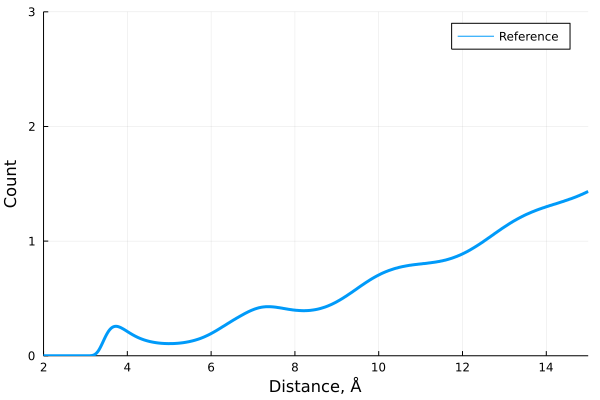

In [11]:
plot(bins, refhist./500, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("Count")

# 3. ML-IMC input parameters

In [12]:
"""
struct inputParms

Fields:
box: box vector, Å
β: 1/(kB*T), reciprocal kJ/mol
Δ: max displacement, Å
steps: total number of steps
Eqsteps: equilibration steps
xyzout: XYZ output frequency
outfreq: output frequency
binWidth: histogram bin width, Å
Nbins: number of histogram bins
"""
struct inputParms
    box::SVector{3, Float64}
    β::Float64
    Δ::Float64  
    steps::Int
    Eqsteps::Int
    xyzout::Int 
    outfreq::Int
    binWidth::Float64
    Nbins::Int
end;

In [13]:
"""
readinput(inputname)

Reads an input file for ML-IMC
and saves the data into the
inputParms struct
"""
function readinput(inputname)
    # Constants
    NA::Float64 = 6.02214076E23 # [mol-1]
    kB::Float64 = 1.38064852E-23 * NA / 1000 # [kJ/(mol*K)]
    # Has to define the variable outside of the main loop
    box = zeros(3)
    β::Float64 = 0.
    Δ::Float64 = 0.
    steps::Int = 0
    Eqsteps::Int = 0
    xyzout::Int = 0
    outfreq::Int = 0
    binWidth::Float64 = 0.
    Nbins::Int = 0
    file = open(inputname, "r")
    lines = readlines(file)
    for line in lines
        if length(line) > 0 && line[1] != '#'
            splittedLine = split(line)
            if splittedLine[1] == "box"
                box[1] = parse(Float64, splittedLine[3])
                box[2] = parse(Float64, splittedLine[4])
                box[3] = parse(Float64, splittedLine[5])
            elseif splittedLine[1] == "temperature"
                T = parse(Float64, splittedLine[3])
                β = 1/(kB * T)
            elseif splittedLine[1] == "delta"
                Δ = parse(Float64, splittedLine[3])
            elseif splittedLine[1] == "steps"
                steps = Int(parse(Float64, splittedLine[3]))
            elseif splittedLine[1] == "Eqsteps"
                Eqsteps = Int(parse(Float64, splittedLine[3]))
            elseif splittedLine[1] == "xyzout"
                xyzout = Int(parse(Float64, splittedLine[3]))
            elseif splittedLine[1] == "outfreq"
                outfreq = Int(parse(Float64, splittedLine[3]))
            elseif splittedLine[1] == "binWidth"
                binWidth = parse(Float64, splittedLine[3])
            elseif splittedLine[1] == "Nbins"
                Nbins = Int(parse(Float64, splittedLine[3]))
            end
        end
    end
    # Save parameters into the inputParms struct
    parameters = inputParms(box, β, Δ, steps, Eqsteps, xyzout, outfreq, binWidth, Nbins)
    return(parameters)
end;

In [14]:
parameters = readinput("LJML-init.in");

In [15]:
parameters.box

3-element SVector{3, Float64} with indices SOneTo(3):
 36.405
 36.405
 36.405

In [16]:
parameters.β

1.266025230073036

In [17]:
parameters.binWidth

0.025

# 4. Compute particle histogram

In [18]:
"""
function histpart!(distanceVector, hist, binWidth, recalculate=false)

Accumulates pair distances from a distance vector
(one particle) to a histogram
"""
function histpart!(distanceVector, hist, binWidth)
    N = length(distanceVector)
    @inbounds @fastmath for i in 1:N
        if distanceVector[i] != 0
            histIndex = floor(Int, 0.5 + distanceVector[i]/binWidth)
            if histIndex <= length(hist)
                hist[histIndex] += 1
            end
        end
    end
    return(hist)
end;

Initialize the distance vector for particle 1:

In [19]:
N = length(confout)
pointIndex = 1
distanceVector = zeros(N)
updatedistance!(confout, parameters.box, distanceVector, pointIndex);

Initialize the distance histogram:

In [20]:
maxR = maximum(bins)
binWidth = bins[2]
Nbins = length(bins)
hist = zeros(Nbins);

Compute the particle histogram:

In [21]:
histpart!(distanceVector, hist, binWidth);

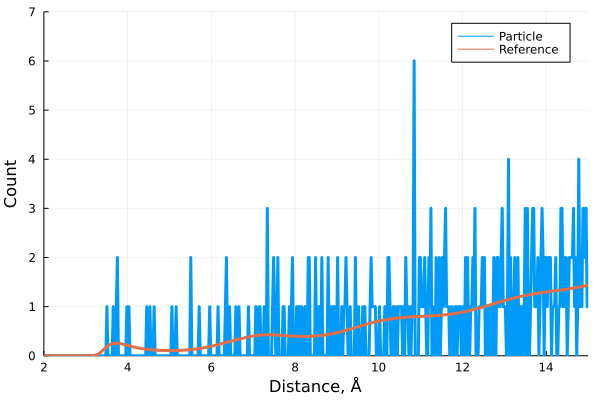

In [22]:
plot(bins, hist, xlim = (2, 15), ylim = (0, 7), linewidth=3, labels="Particle")
plot!(bins, refhist./500, xlim = (2, 15), ylim = (0, 7), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("Count")

# 5. Building the neural network

Initialize a net with `Nbins` neurons (600) in the input layer and 1 neuron in the output layer. One bias parameter is introduced. Hyperbolic tangent (tanh) is used as the activation function. I think tanh is a good option, because the result can be either negative or positive.

In [23]:
model = Dense(length(hist), 1, tanh, bias=true)

Dense(600, 1, tanh)  # 601 parameters

Network weigths (potential parameters):

In [24]:
model.weight

1×600 Matrix{Float32}:
 -0.0412115  -0.0951333  0.0922577  …  -0.0367496  -0.0243304  0.00348933

In [25]:
model.bias

1-element Vector{Float32}:
 0.0

Use the model to predict energy from the particle histogram:

In [26]:
E = model(hist)

1-element Vector{Float64}:
 -0.07545025103110511

# 6. Neural network Monte Carlo

In [27]:
"""
neuralenergy(hist, model)

Computes the potential energy of one particle
distance histogram using the neural network
"""
function neuralenergy(hist, model)
    E::Float64 = model(hist)[1]
    return(E)
end;

In [28]:
neuralenergy(hist, model)

-0.07545025103110511

Now I need to write the function for MC moves. One important aspect here is that I need to sample particle histograms very frequently (around 500 times more often than with the total histogram).

In [29]:
function mcmove!(conf, E, step, parameters, model, histNN, rng)
    # Pick a particle
    pointIndex = rand(rng, Int32(1):Int32(length(conf)))
    
    # Allocate and compute the distance vector
    distanceVector = zeros(length(conf))
    updatedistance!(conf, parameters.box, distanceVector, pointIndex)
    
    # Allocate and compute the histogram
    hist1 = zeros(parameters.Nbins)
    histpart!(distanceVector, hist1, parameters.binWidth)
    
    # Compute the energy
    E1 = neuralenergy(hist1, model)
    
    # Displace the particle
    dr = SVector{3, Float64}(parameters.Δ*(rand(rng, Float64) - 0.5), 
                             parameters.Δ*(rand(rng, Float64) - 0.5), 
                             parameters.Δ*(rand(rng, Float64) - 0.5))
    
    conf[pointIndex] += dr
    
    # Update distance and compute the new histogram
    hist2 = zeros(parameters.Nbins)
    updatedistance!(conf, parameters.box, distanceVector, pointIndex)
    histpart!(distanceVector, hist2, parameters.binWidth)
    
    # Compute the energy again
    E2 = neuralenergy(hist2, model)
    
    # Get energy difference
    ΔE = E2 - E1
    # Acceptance counter
    accepted = 0
    
    if rand(rng, Float64) < exp(-ΔE*parameters.β)
        accepted += 1
        E += ΔE
        # Add the particle histogram to the total histogram
        if step % parameters.outfreq == 0 && step > parameters.Eqsteps
            for i in 1:parameters.Nbins
                 histNN[i] += hist2[i] 
            end
        end
    else
        conf[pointIndex] -= dr
        # Add the particle histogram to the total histogram
        if step % parameters.outfreq == 0 && step > parameters.Eqsteps
            for i in 1:parameters.Nbins
                 histNN[i] += hist1[i] 
            end
        end
    end
    return(conf, E, histNN, accepted)
end

mcmove! (generic function with 1 method)

I need to decide how I accumulate the histograms. It makes sense to accumulate them if I compute them, but I also need a possibility to recompute them. Also, I need to decide whether I use the distance matrix or not.

I think I have come up with a way - I need to allocate three histograms: two intermediates and one accumulator.

# 6.1 Running a few moves

Checking/initializing some of the inputs...

In [30]:
function mcrun(conf, parameters, model)
    dataPoints = Int(parameters.steps / parameters.outfreq)
    energies = zeros(dataPoints + 1)
    E = 0.
    histNN = zeros(parameters.Nbins)
    rng_xor = RandomNumbers.Xorshifts.Xoroshiro128Plus()
    acceptedTotal = 0
    @inbounds @fastmath for step in 1:parameters.steps
        conf, E, histNN, accepted = mcmove!(conf, E, step, parameters, model, histNN, rng_xor)
        acceptedTotal += accepted
        if step % parameters.outfreq == 0
            energies[Int(step/parameters.outfreq) + 1] = E
        end
    end
    acceptanceRatio = acceptedTotal / parameters.steps
    histNN = histNN./dataPoints
    println("Acceptance ratio = $(acceptanceRatio)")
    return(histNN, energies, acceptanceRatio)
end

mcrun (generic function with 1 method)

In [37]:
bins, refrdf, refhist = readRDF("rdf-mean-p40.dat");

In [38]:
confout = xyz[end];

In [52]:
parameters = readinput("LJML-init.in");

In [40]:
model = Dense(length(refhist), 1, tanh, bias=true);

In [53]:
@time histNN, energies, acceptanceRatio = mcrun(confout, parameters, model);

Acceptance ratio = 0.637288
 33.758334 seconds (8.36 M allocations: 17.089 GiB, 1.89% gc time)


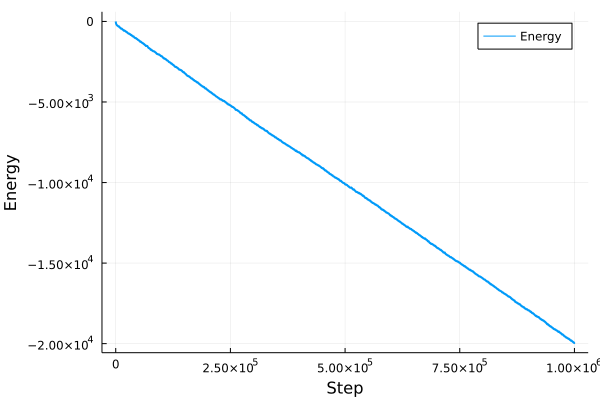

In [50]:
plot(0:parameters.outfreq:parameters.steps, energies, lw=2, labels="Energy")
xlabel!("Step")
ylabel!("Energy")

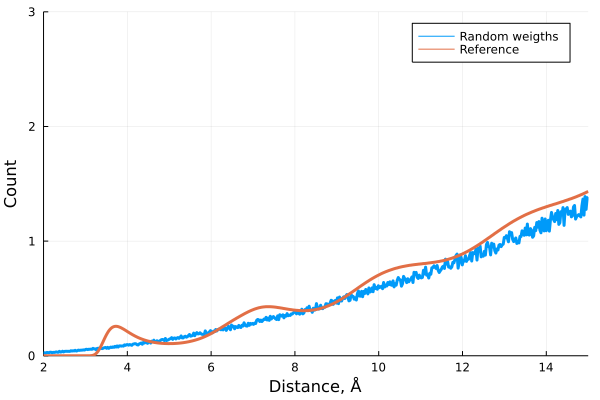

In [51]:
plot(bins, histNN, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Random weigths")
plot!(bins, refhist./500, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("Count")

This doesn't look too bad! I need to manage the way I sample the histogram though.